#Домашнее задание № 4. Модели авторегрессии условной гетероскедантичности.

##Загрузим необходимые данные

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# загрузим данные
!wget 'https://u.netology.ru/backend/uploads/lms/attachments/files/data/47497/1._Лекция_tsml.zip'

--2025-02-25 05:47:15--  https://u.netology.ru/backend/uploads/lms/attachments/files/data/47497/1._%D0%9B%D0%B5%D0%BA%D1%86%D0%B8%D1%8F_tsml.zip
Resolving u.netology.ru (u.netology.ru)... 213.180.193.247, 2a02:6b8::1da
Connecting to u.netology.ru (u.netology.ru)|213.180.193.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 769056 (751K) [application/x-zip-compressed]
Saving to: ‘1._Лекция_tsml.zip’

1._Лекция_tsml.zip  100%[===================>] 751.03K   437KB/s    in 1.7s    

2025-02-25 05:47:18 (437 KB/s) - ‘1._Лекция_tsml.zip’ saved [769056/769056]



In [3]:
# распакуем
import zipfile

with zipfile.ZipFile('/content/1._Лекция_tsml.zip', 'r') as zip_ref:
    zip_ref.extractall('unpacked_files')

В качестве ряда для анализа выберу monthly_boston_armed_robberies_j. Он мне кажется самым интересным.

In [4]:
# 2. ежемесячные_бостонские вооруженные_ ограбления_j
monthly_boston_armed_robberies_j = pd.read_csv('/content/unpacked_files/Series/monthly-boston-armed-robberies-j.csv')

In [5]:
series = monthly_boston_armed_robberies_j['Count']

In [6]:
# вывод графика
def chart(series, title='Временной ряд'):
    plt.figure(figsize=(14, 7))
    plt.plot(series, label=title)
    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Величина')
    plt.grid(False)
    plt.legend()
    plt.show()

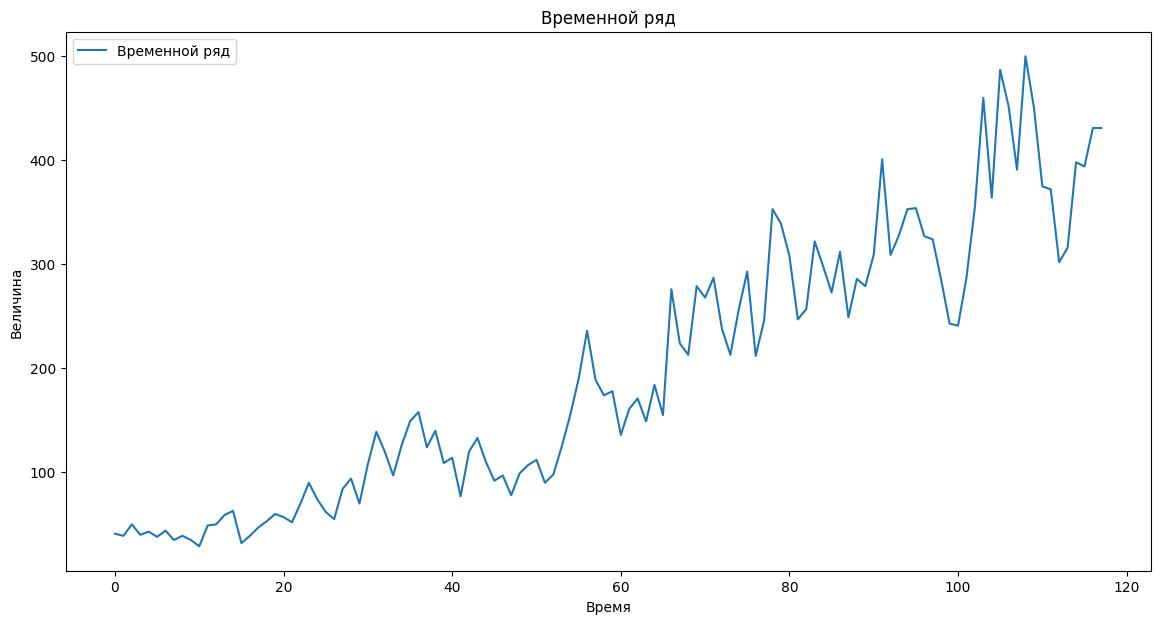

In [7]:
# еще раз на него посмотрим
chart(series)

##Модель GARCH

##Перебираем комбинации моделей ARIMA(p, d, q), чтобы подобрать наиболее подходящую для нашего временного ряда.

In [8]:
# загрузим библиотеки
from statsmodels.tsa.arima.model import ARIMA
import itertools

In [9]:
# отключаем сообщения об ошибках
import warnings
warnings.filterwarnings('ignore')

# для поиска наилучших параметров воспользуемся поиском по сетке
p = range(0,15)
d = q = range(0,3)
pdq = list(itertools.product(p, d, q))
print(f'Всего рассмотрим {len(pdq)} вариантов')
best_pdq = (0,0,0)

# для поиска лучшей модели воспользуемся информационным критерием aic.
# AIC — Akaike Information Criterion). AIC оценивает, насколько хорошо модель подходит под данные.
# чем меньше AIC – тем точнее модель
best_aic = np.inf

for params in pdq:
    model_test = ARIMA(series, order=params)
    result_test = model_test.fit()

    if result_test.aic < best_aic:
        best_pdq = params
        best_aic = result_test.aic
        result = result_test
print(best_pdq, best_aic)

Всего рассмотрим 135 вариантов
(11, 2, 1) 1170.5123599546882


In [10]:
# проверим оптимальность модели
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Count   No. Observations:                  118
Model:                ARIMA(11, 2, 1)   Log Likelihood                -572.256
Date:                Tue, 25 Feb 2025   AIC                           1170.512
Time:                        05:50:26   BIC                           1206.309
Sample:                             0   HQIC                          1185.044
                                - 118                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4821      0.096     -4.998      0.000      -0.671      -0.293
ar.L2         -0.4306      0.081     -5.336      0.000      -0.589      -0.272
ar.L3         -0.2631      0.110     -2.402      0.016      -0.478      -0.048
ar.L4         -0.4375      0.104     -4.189      0.000      -0.642      -0.233
ar.L5         -0.2273      0.109     -2.077      0.038      -0.442      -0.013
ar.L6         -0.3339      0.096     -3.461      0.001      -0.523      -0.145
ar.L7         -0.4220      0.101     -4.198      0.000      -0.619      -0.225
ar.L8         -0.2848      0.117     -2.440      0.015      -0.513      -0.056
ar.L9         -0.3873      0.112     -3.447      0.001      -0.608      -0.167
ar.L10        -0.4829      0.130     -3.709      0.000      -0.738      -0.228
ar.L11        -0.2770      0.100     -2.767      0.006      -0.473      -0.081
ma.L1         -0.9689      0.034    -28.236      0.000      -1.036      -0.902
sigma2      1041.5759    125.746      8.283      0.000     795.119    1288.033
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                21.30
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               5.56   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Здесь нас интересует таблица коэффициентов. Столбец coef показывает влияние каждого параметра на временной ряд, а P>|z| — значимость. Чем ближе значение P>|z| к нулю, тем выше значимость.

Вторым методом модели, который может помочь в оценке модели — plot_diagnostics().

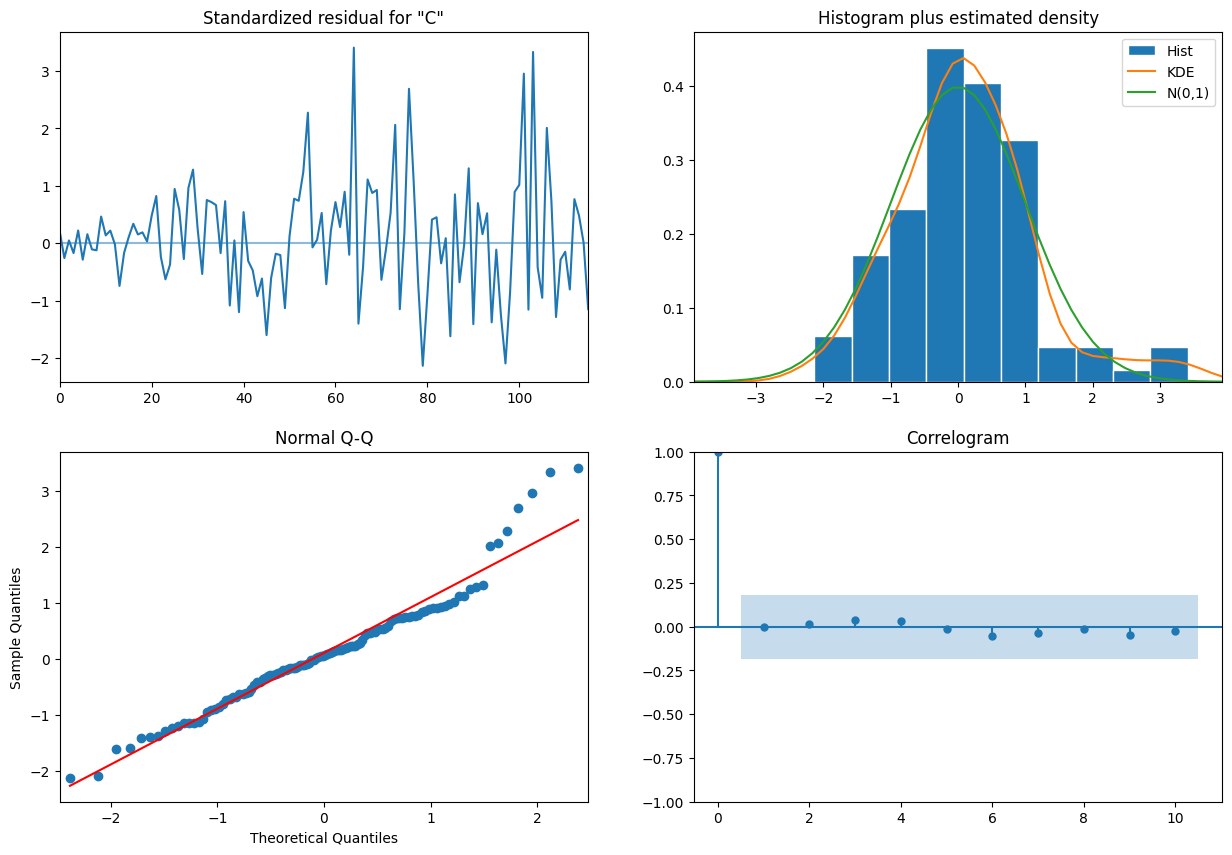

In [11]:
result.plot_diagnostics(figsize=(15, 10))
plt.show()

Остатки имеют нормальное распределение и близкую к нулю в автокорреляции.



##Выберите модель GARCH в соответствии с моделью ARIMA с наименьшим значением AIC.

In [12]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.0 MB/s eta 0:00:00


In [13]:
# импортируем модель
from arch import arch_model

In [18]:
# возьмем наши лучшие парамеры
print(f'модель ARIMA(p,d,q): p={best_pdq[0]}, d={best_pdq[1]}, g={best_pdq[2]}')

модель ARIMA(p,d,q): p=11, d=2, g=1


In [15]:
# разобъем временной ряд на train/test
n_test = int(len(series)*0.2)
train, test = series[:-n_test], series[-n_test:]
train[:3], test[:3]

(0    41
 1    39
 2    50
 Name: Count, dtype: int64,
 95    354
 96    327
 97    324
 Name: Count, dtype: int64)

In [16]:
# определим модель
model = arch_model(train, mean='Zero', vol='GARCH', p=15, q=15)

# обучим модель
model_fit = model.fit()

# получим прогноз
y_pred = model_fit.forecast(horizon=n_test)

# построим график фактической дисперсии
var = [i*0.01 for i in range(0,100)]

pyplot.plot(var[-n_test:])
# plot forecast variance
pyplot.plot(yhat.variance.values[-1, :])
pyplot.show()